In [39]:
import pandas as pd

df = pd.read_csv("transactions_dataset.csv", sep=";")

In [40]:
client_churned = pd.read_excel("churned_clients_final.xlsx")

In [41]:
import gc

gc.collect()

38967

In [42]:
relationship = pd.read_csv("sales_client_relationship_dataset.csv")
relationship

,client_id,quali_relation
0,188502,Difficult client
1,598816,Difficult client
2,564878,Difficult client
3,1883627,Difficult client
4,224223,Difficult client
...,...,...
170584,530092,Agreeable client
170585,1511299,Agreeable client
170586,593718,Agreeable client
170587,1349732,Agreeable client


In [43]:
# Filter the df dataframe to keep only the clients that are present in client_churned
churned_df = df[df["client_id"].isin(client_churned["client_id"])]
# Merge churned_df with relationship on 'client_id'
churned_df = pd.merge(churned_df, relationship, on="client_id", how="left")
predicted = pd.read_csv("predicted_churners_sales_method1.csv")


"""
80€/hour.
- 3 hours to complete with usually 1 additional hour of follow-up
- 1 hours Phone call

Demanding client: 5 hours
Diifficult client: 4 hours
Agreeable client: 1 hour phone call
"""

churned_df["Cost"] = churned_df["quali_relation"].map(
    {
        "Demanding client": 20 * 80,
        "Difficult client": 12 * 80,
        "Agreeable client": 8 * 80,
    }
)


churned_df = pd.merge(predicted, churned_df, on="client_id", how="left")

churned_df = churned_df[["client_id", "expected_sales_2020_method1", "Cost"]]
churned_df.drop_duplicates(inplace=True)
churned_df


,client_id,expected_sales_2020_method1,Cost
0,60,0.000000,1600
7,67,18162.404424,640
12,68,21268.612082,1600
95,76,2437.681335,960
104,120,2456.972774,640
...,...,...,...
2605456,2274173,23078.726225,640
2605503,2274269,6452.931358,1600
2605530,2274425,161.097155,640
2605534,2274479,315.101565,640


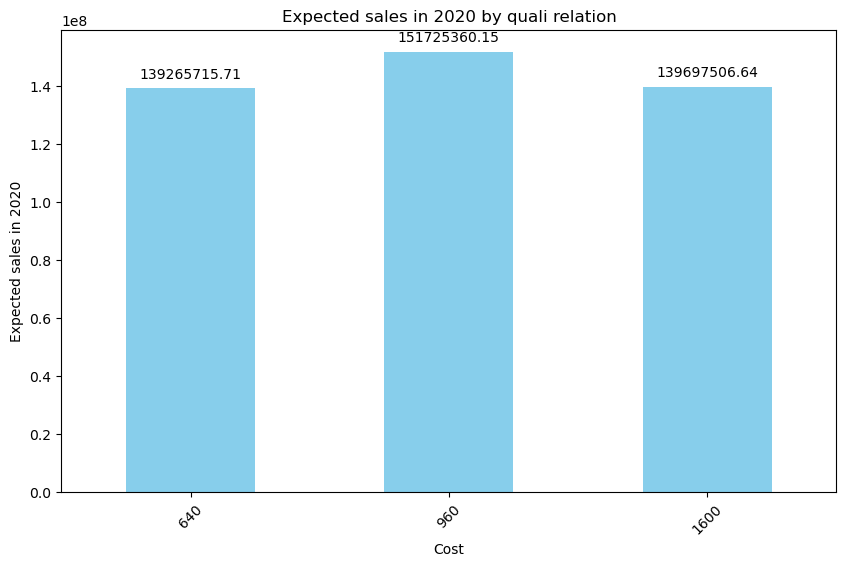

In [63]:
# Plot expected sales in churned_df by quali relation
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = (
    churned_df.groupby("Cost")["expected_sales_2020_method1"]
    .sum()
    .plot(kind="bar", color="skyblue")
)
plt.title("Expected sales in 2020 by quali relation")
plt.ylabel("Expected sales in 2020")
plt.xticks(rotation=45)

# Add the value of each bar on top of the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.show()


In [53]:
churned_df["Cost"].value_counts()

Cost
1600    13016
960     12958
640     12832
Name: count, dtype: int64

In [54]:
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus


def knapsack_with_client_id(df, budget=100000):
    """
    Solve a 0-1 knapsack where:
      - Weight = df['Cost']
      - Value  = df['expected_sales_2020_method1']
      - Capacity (budget) = 100000 (default)
    Returns a tuple: (chosen_df, total_cost, total_sales)
    """

    # 1) Create the optimization model
    model = LpProblem("Knapsack_Problem", sense=LpMaximize)

    # 2) Create a binary decision variable for each client_id
    #    Key the dictionary by client_id instead of DataFrame index
    x = {cid: LpVariable(f"x_{cid}", cat="Binary") for cid in df["client_id"].unique()}

    # 3) Define the objective: maximize sum of (x[cid] * expected_sales)
    model += (
        lpSum(
            [
                x[row["client_id"]] * row["expected_sales_2020_method1"]
                for _, row in df.iterrows()
            ]
        ),
        "MaxExpectedSales",
    )

    # 4) Define the constraint: total Cost <= budget
    model += (
        lpSum([x[row["client_id"]] * row["Cost"] for _, row in df.iterrows()])
        <= budget,
        "BudgetConstraint",
    )

    # 5) Solve the model
    model.solve()

    print("Solver Status:", LpStatus[model.status])

    # 6) Collect chosen clients (where x[cid] == 1)
    chosen_client_ids = [cid for cid in x if x[cid].varValue == 1]

    # 7) Filter original DF by chosen clients
    chosen_df = df[df["client_id"].isin(chosen_client_ids)].copy()

    # 8) Compute total cost & total expected sales
    total_cost = chosen_df["Cost"].sum()
    total_sales = chosen_df["expected_sales_2020_method1"].sum()

    return chosen_df, total_cost, total_sales


chosen_df, total_cost, total_sales = knapsack_with_client_id(churned_df, budget=100000)

print("Number of chosen clients:", len(chosen_df))
print("Total Cost:", total_cost)
print("Total Expected Sales:", total_sales)

Solver Status: Optimal
Number of chosen clients: 115
Total Cost: 99840
Total Expected Sales: 69801636.03416082


In [55]:
chosen_df

,client_id,expected_sales_2020_method1,Cost
22289,25087,5.948931e+05,1600
29492,31490,3.229647e+05,640
33250,36349,3.271973e+05,960
45611,49886,1.189535e+06,960
109779,108011,3.170585e+05,640
...,...,...,...
2560771,2237003,3.301934e+05,640
2565131,2240328,7.074436e+05,1600
2569125,2245720,7.767226e+05,640
2588463,2261470,4.762579e+05,640


In [56]:
gc.collect()

417

In [57]:
final_df = pd.merge(chosen_df, relationship, on="client_id")

In [58]:
final_df

,client_id,expected_sales_2020_method1,Cost,quali_relation
0,25087,5.948931e+05,1600,Demanding client
1,31490,3.229647e+05,640,Agreeable client
2,36349,3.271973e+05,960,Difficult client
3,49886,1.189535e+06,960,Difficult client
4,108011,3.170585e+05,640,Agreeable client
...,...,...,...,...
110,2237003,3.301934e+05,640,Agreeable client
111,2240328,7.074436e+05,1600,Demanding client
112,2245720,7.767226e+05,640,Agreeable client
113,2261470,4.762579e+05,640,Agreeable client


In [59]:
final_df["quali_relation"].value_counts()

quali_relation
Agreeable client    63
Difficult client    37
Demanding client    15
Name: count, dtype: int64

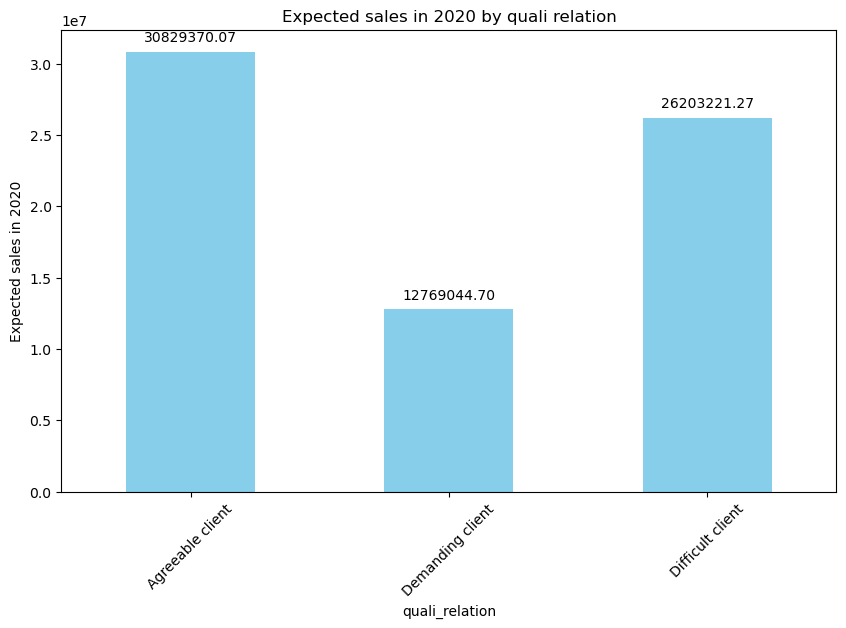

In [64]:
# Plot expected sales in churned_df by quali relation
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = (
    final_df.groupby("quali_relation")["expected_sales_2020_method1"]
    .sum()
    .plot(kind="bar", color="skyblue")
)
plt.title("Expected sales in 2020 by quali relation")
plt.ylabel("Expected sales in 2020")
plt.xticks(rotation=45)

# Add the value of each bar on top of the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.show()


In [61]:
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus


def knapsack_with_fractional_allocation(df, budgets=[50000, 100000, 150000]):
    """
    Solve a fractional knapsack where:
      - Cost = df['Cost']
      - Value = df['expected_sales_2020_method1']
      - Capacity (budget) = Variable
    Runs for multiple budgets and returns the best allocation for each.
    """

    results = []

    for budget in budgets:
        print(f"\n🔹 Running Knapsack for Budget: €{budget}")

        # 1) Create the optimization model
        model = LpProblem("Knapsack_Problem", sense=LpMaximize)

        # 2) Create continuous decision variables (fractional allocation)
        x = {
            cid: LpVariable(f"x_{cid}", lowBound=0, upBound=1, cat="Continuous")
            for cid in df["client_id"].unique()
        }

        # 3) Define the objective: maximize sum of (x[cid] * expected_sales)
        model += (
            lpSum(
                x[row["client_id"]] * row["expected_sales_2020_method1"]
                for _, row in df.iterrows()
            ),
            "MaxExpectedSales",
        )

        # 4) Define the constraint: total Cost ≤ budget
        model += (
            lpSum(x[row["client_id"]] * row["Cost"] for _, row in df.iterrows())
            <= budget,
            "BudgetConstraint",
        )

        # 5) Solve the model
        model.solve()

        print("Solver Status:", LpStatus[model.status])

        # 6) Collect chosen clients (where x[cid] > 0)
        chosen_client_ids = [cid for cid in x if x[cid].varValue > 0]

        # 7) Filter original DF by chosen clients and allocate fractional hours
        chosen_df = df[df["client_id"].isin(chosen_client_ids)].copy()
        chosen_df["Allocation %"] = chosen_df["client_id"].apply(
            lambda cid: x[cid].varValue
        )
        chosen_df["Allocated Cost"] = chosen_df["Allocation %"] * chosen_df["Cost"]
        chosen_df["Allocated Sales"] = (
            chosen_df["Allocation %"] * chosen_df["expected_sales_2020_method1"]
        )

        # 8) Compute total cost & total expected sales
        total_cost = chosen_df["Allocated Cost"].sum()
        total_sales = chosen_df["Allocated Sales"].sum()

        # Store results
        results.append(
            {
                "Budget": budget,
                "Clients Chosen": len(chosen_client_ids),
                "Total Cost": total_cost,
                "Total Expected Sales": total_sales,
            }
        )

        print(
            f"✅ Budget: €{budget} | Clients: {len(chosen_client_ids)} | Sales: €{total_sales:,.2f}"
        )
        print(f"ROI = {total_sales / total_cost:.2f}")

    return results


In [62]:
# Run the fractional allocation model
budget_results = knapsack_with_fractional_allocation(
    churned_df, budgets=[50000, 100000, 150000, 200000, 250000]
)



🔹 Running Knapsack for Budget: €50000
Solver Status: Optimal
✅ Budget: €50000 | Clients: 64 | Sales: €51,015,544.82
ROI = 1020.31

🔹 Running Knapsack for Budget: €100000
Solver Status: Optimal
✅ Budget: €100000 | Clients: 116 | Sales: €69,853,242.51
ROI = 698.53

🔹 Running Knapsack for Budget: €150000
Solver Status: Optimal
✅ Budget: €150000 | Clients: 173 | Sales: €84,168,667.35
ROI = 561.12

🔹 Running Knapsack for Budget: €200000
Solver Status: Optimal
✅ Budget: €200000 | Clients: 232 | Sales: €96,004,686.99
ROI = 480.02

🔹 Running Knapsack for Budget: €250000
Solver Status: Optimal
✅ Budget: €250000 | Clients: 295 | Sales: €106,135,928.58
ROI = 424.54


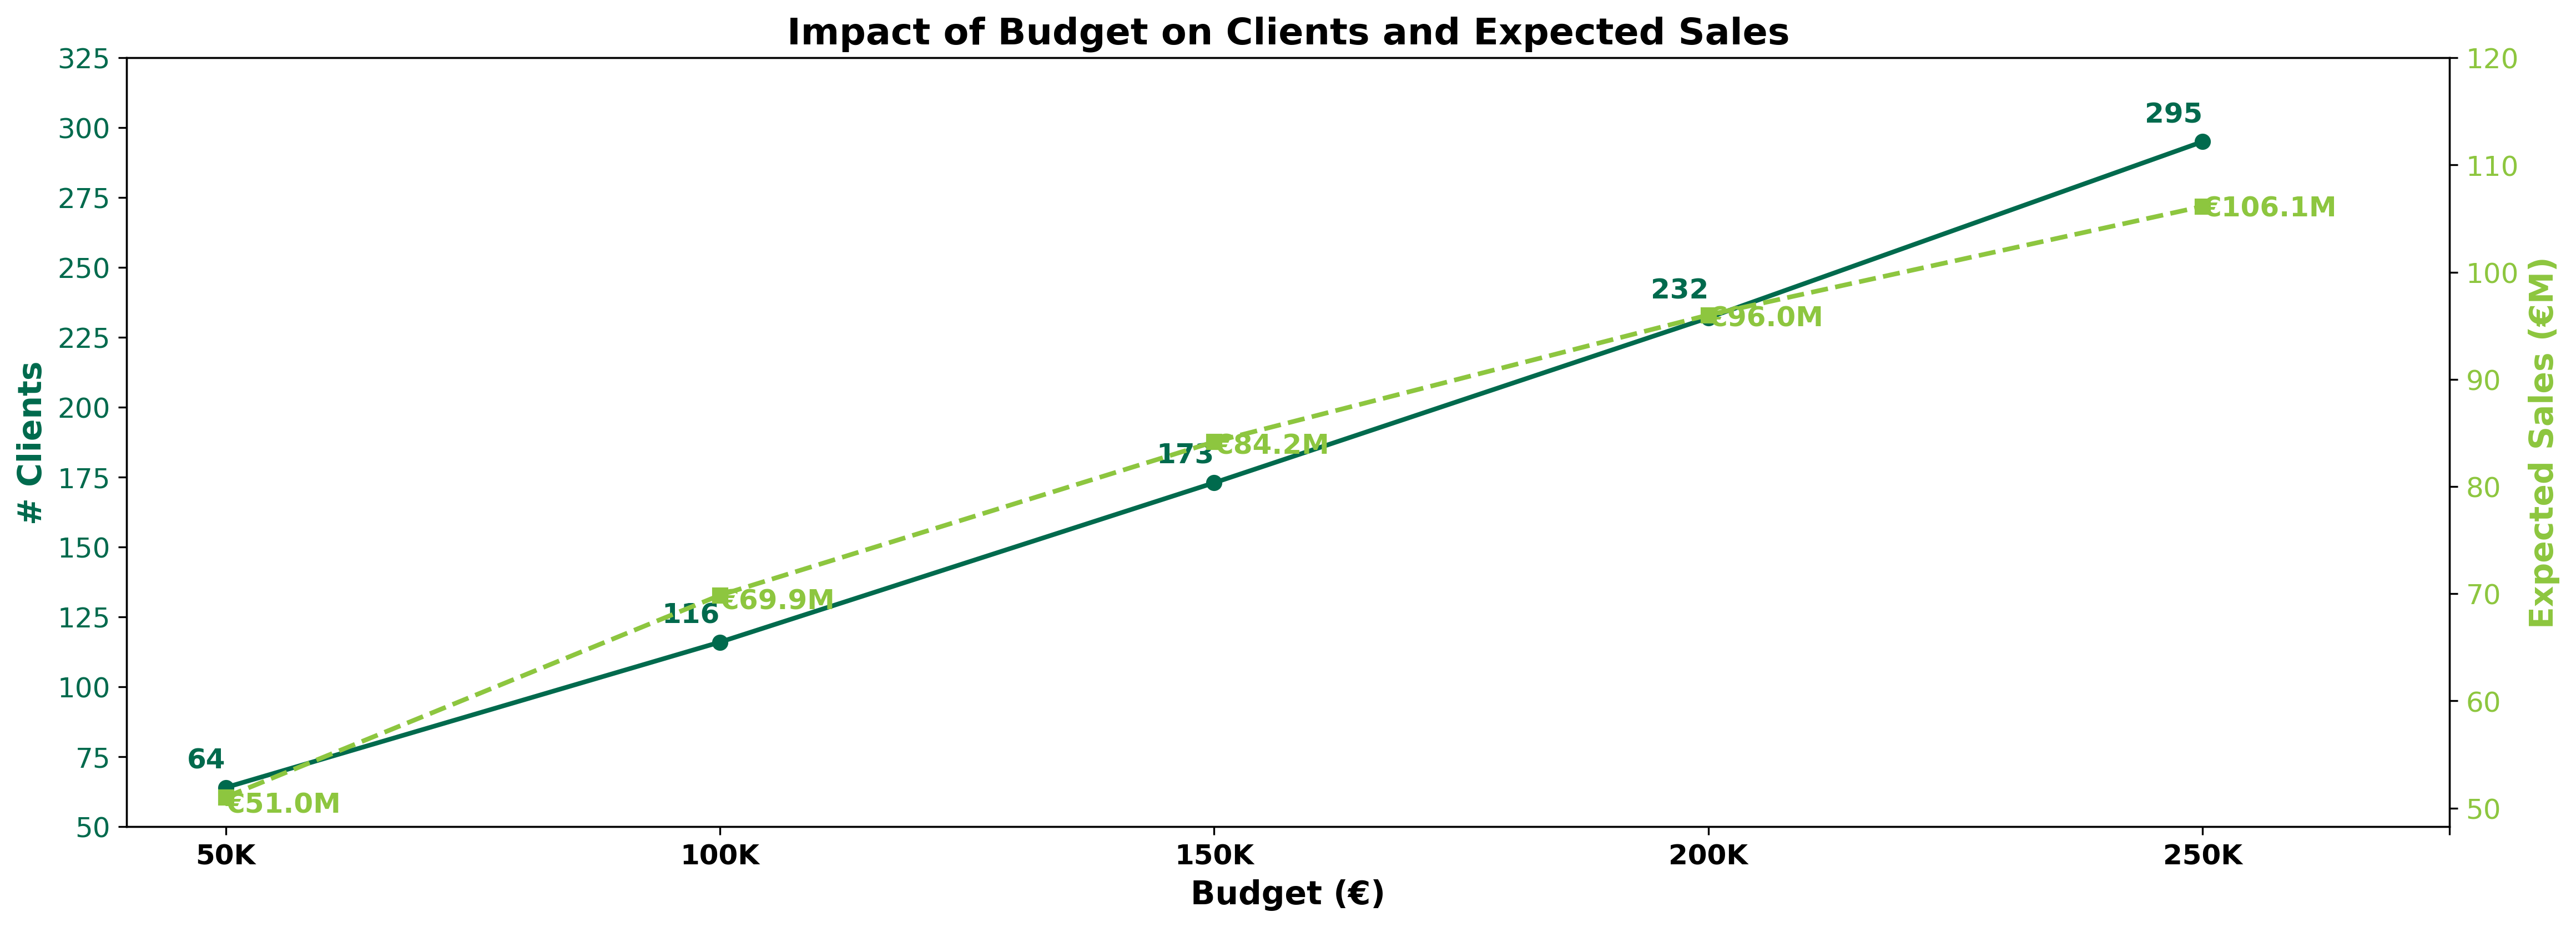

In [38]:
import matplotlib.pyplot as plt

# BCG Colors
bcg_green = "#006A4D"
bcg_light_green = "#8DC63F"

# Data
budgets = [50000, 100000, 150000, 200000, 250000]
clients = [64, 116, 173, 232, 295]  # Slightly adjusted for staggered effect
sales = [51015544.82, 69853242.51, 84168667.35, 96004686.99, 106135928.58]
sales_millions = [s / 1e6 for s in sales]  # Convert to millions (€M)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(18, 6), dpi=300)
fig.patch.set_alpha(0)  # Transparent background for the figure
ax1.patch.set_alpha(0)  # Transparent background for the axes

# Left Y-axis for Clients
ax1.set_xlabel("Budget (€)", fontsize=14, fontweight="bold")
ax1.set_ylabel("# Clients", color=bcg_green, fontsize=14, fontweight="bold")
ax1.plot(
    budgets,
    clients,
    marker="o",
    linestyle="-",
    color=bcg_green,
    label="Number of Clients",
    linewidth=2,
)
ax1.tick_params(axis="y", labelcolor=bcg_green, labelsize=12)
ax1.set_yticks(range(50, 350, 25))  # Flatten the curve visually

# Right Y-axis for Expected Sales (€M)
ax2 = ax1.twinx()
ax2.set_ylabel(
    "Expected Sales (€M)", color=bcg_light_green, fontsize=14, fontweight="bold"
)
ax2.plot(
    budgets,
    sales_millions,
    marker="s",
    linestyle="--",
    color=bcg_light_green,
    label="Expected Sales",
    linewidth=2,
)
ax2.tick_params(axis="y", labelcolor=bcg_light_green, labelsize=12)
ax2.set_yticks(range(50, 130, 10))  # Flatten sales scale
ax2.patch.set_alpha(0)  # Transparent background for the second y-axis

# Labels for points
for i in range(len(budgets)):
    ax1.text(
        budgets[i],
        clients[i] + 5,
        f"{clients[i]}",
        color=bcg_green,
        fontsize=12,
        fontweight="bold",
        ha="right",
        va="bottom",
    )
    ax2.text(
        budgets[i],
        sales_millions[i] * 1.01,  # Slight vertical adjustment
        f"€{sales_millions[i]:,.1f}M",
        color=bcg_light_green,
        fontsize=12,  # Corrected fontsize
        fontweight="bold",
        ha="left",
        va="top",
    )

# X-Axis Formatting
ax1.set_xticks(budgets + [275000])  # Add extra tick for visual balance
ax1.set_xticklabels(
    ["50K", "100K", "150K", "200K", "250K", ""], fontsize=12, fontweight="bold"
)

# Title
plt.title(
    "Impact of Budget on Clients and Expected Sales", fontsize=16, fontweight="bold"
)

# Show the plot
plt.show()
